##**PROJECT TITLE :** 

## **MODEL FOR ASSISTING BLIND PEOPLE BY OBJECT/PEOPLE AND ACTIVITY DETECTION (BRIEF CAPTION/DESCRIPTION) WITH VOICE DESCRIPTION** 

### **Done By**

### **Suhas Preetham Kambham - CB.EN.P2CSE21008**
### **Raahul Varman - CB.EN.P2CSE21012**





### **PROBLEM STATEMENT**

### *Design and implement a deep learning model that can capture the images and alert the visually impaired individual by detecting objects and/or activities that are happening in the image (a brief captioning/description) through a speech generation module added to the object/activity detection architecture .*

### **IMPLEMENTATION**

In [ ]:
# Installing required dependencies

!git clone https://github.com/AllenDowney/ThinkDSP.git 
!pip install gtts

Cloning into 'ThinkDSP'...
remote: Enumerating objects: 2469, done.
remote: Total 2469 (delta 0), reused 0 (delta 0), pack-reused 2469
Receiving objects: 100% (2469/2469), 208.82 MiB | 28.07 MiB/s, done.
Resolving deltas: 100% (1353/1353), done.
Checking out files: 100% (302/302), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Importing required libraries

import tensorflow as tf
import matplotlib.pyplot as plt
import collections
import random
import numpy as np
import os
import time
import json
from PIL import Image
from keras.preprocessing import image
import sys
sys.path.insert(0, 'ThinkDSP/code/') 
import thinkdsp
import IPython
from gtts import gTTS

### **Downloading and preparing the MS-COCO dataset**

Dataset used : MS-COCO dataset 

The dataset contains over 82,000 images, each of which has 5 different caption annotations. 



In [ ]:
# Downloading caption annotation files
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                           extract=True)
  annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
  os.remove(annotation_zip)

# Downloading image files
image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin='http://images.cocodataset.org/zips/train2014.zip',
                                      extract=True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

13510582272/13510573713 [==============================] - 212s 0us/step


### **Limited the size of the training set**
A subset of 1,50,000 captions and their corresponding images are used to train the model. 

In [ ]:
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

In [ ]:
# All captions having the same image ID are grouped together

image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
  caption = f"<start> {val['caption']} <end>"
  image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
  image_path_to_caption[image_path].append(caption)

In [ ]:
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)
train_image_paths = image_paths[:30000] # Selecting the first 30000 images 


In [ ]:
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))

<start> A white car driving down a rain soaked street. <end>


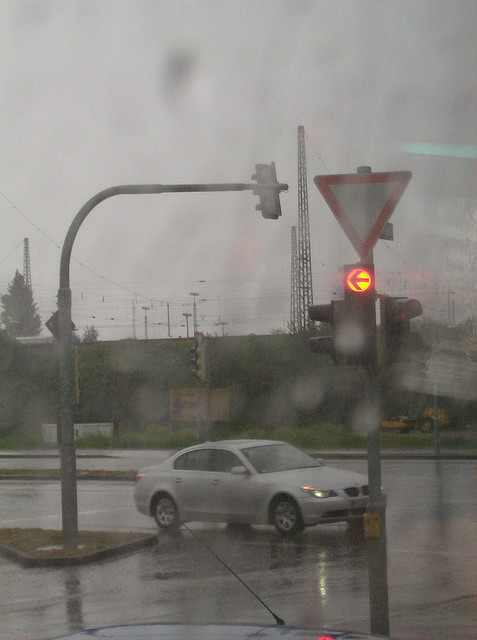

In [ ]:
print(train_captions[100])
Image.open(img_name_vector[100])

### **Preprocess the images using MobileNet**
The MobileNet (which is pretrained on Imagenet) is used to classify each image. Features are extracted from the images from the last convolutional layer of MobileNet

Images are first converted into MobileNet's expected format by:
* Resizing the image to 224px by 224px
* Image preprocessing is done using the preprocess_input method to normalize the image so that it contains pixels in the range of -1 to 1, which matches the format of the images used to train MobileNet.

In [ ]:

def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(224, 224)(img)
    img = tf.keras.applications.mobilenet.preprocess_input(img)
    return img, image_path

### **Initialize MobileNet and load the pretrained Imagenet weights**

We create a model where the output layer is the last convolutional layer in the MobileNet architecture. The shape of the output of this layer is 7x7x1024. We use the last convolutional layer because we are using attention in this project.

* each image is forwarded through the network and the resulting vector is stored in a dictionary (image_name --> feature_vector).
* After all the images are passed through the network, we save the dictionary to disk.


In [ ]:
image_model = tf.keras.applications.mobilenet.MobileNet(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

17235968/17225924 [==============================] - 0s 0us/step


### **Caching the features extracted from MobileNet**

Each image is preprocessed with MobileNet and the output is cached to disk. 




In [ ]:
# Get unique images
encode_train = sorted(set(img_name_vector))

image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

for img, path in image_dataset:
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

### **Preprocessing and tokenizing the captions**

Transforming the text captions into integer sequences using the TextVectorization layer, with the following steps:

* Adapt is used to iterate over all captions, split the captions into words, and compute a vocabulary of the top 5,000 words (to save memory).
* All captions are tokenised by mapping each word to its index in the vocabulary. All output sequences will be padded to length 50.
* Word-to-index and index-to-word mappings to display results.

In [ ]:
caption_dataset = tf.data.Dataset.from_tensor_slices(train_captions)

def standardize(inputs):
  inputs = tf.strings.lower(inputs)
  return tf.strings.regex_replace(inputs,
                                  r"!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~", "")

# Max word count for a caption.
max_length = 50
# Use the top 5000 words for a vocabulary.
vocabulary_size = 5000
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    output_sequence_length=max_length)
# Learn the vocabulary from the caption data.
tokenizer.adapt(caption_dataset)

In [ ]:
# Create the tokenized vectors
cap_vector = caption_dataset.map(lambda x: tokenizer(x))

In [ ]:
# Create mappings for words to indices and indices to words.
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

### **Splitting the data into train and test**

In [ ]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

# Create training and validation sets 80-20 split.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

In [ ]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(120055, 120055, 30013, 30013)

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
num_steps = len(img_name_train) // BATCH_SIZE

# Shape of the vector extracted from MobileNet is (49, 1024)
features_shape = 1024
attention_features_shape = 49

In [ ]:
# Loading the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int64]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

### **Model building**

* Extracting the features from the lower convolutional layer of MobileNet giving a vector of shape (7, 7, 1024).
* Squashing that to a shape of (49, 1024).
* This vector is then passed through the CNN Encoder (which consists of a single Fully connected layer).
* The GRU attends over the image to predict the next word.

In [ ]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
 
    hidden_with_time_axis = tf.expand_dims(hidden, 1)


    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))
    score = self.V(attention_hidden_layer)

 
    attention_weights = tf.nn.softmax(score, axis=1)

    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
class CNN_Encoder(tf.keras.Model):
    
    #  encoder passes features already extracted from mobilenet through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [ ]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    x = self.embedding(x)


    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)


    output, state = self.gru(x)

    x = self.fc1(output)

    x = tf.reshape(x, (-1, x.shape[2]))

    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [ ]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, tokenizer.vocabulary_size())

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [ ]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  ckpt.restore(ckpt_manager.latest_checkpoint)

### **Training**

* Extracting the features stored in the respective .npy files and then pass those features through the encoder.
* The encoder output, hidden state(initialized to 0) and the decoder input (which is the start token) is passed to the decoder.
* The decoder returns the predictions and the decoder hidden state.
* The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
* Teacher forcing is the technique where the target word is passed as the next input to the decoder.
* The final step is to calculate the gradients and apply it to the optimizer and backpropagate.


In [ ]:

loss_plot = []

In [ ]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([word_to_index('<start>')] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [ ]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
  
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 1.9205
Epoch 1 Batch 100 Loss 1.0825
Epoch 1 Batch 200 Loss 0.9117
Epoch 1 Batch 300 Loss 0.8527
Epoch 1 Batch 400 Loss 0.7658
Epoch 1 Batch 500 Loss 0.8426
Epoch 1 Batch 600 Loss 0.8301
Epoch 1 Batch 700 Loss 0.7557
Epoch 1 Batch 800 Loss 0.7158
Epoch 1 Batch 900 Loss 0.6862
Epoch 1 Batch 1000 Loss 0.8176
Epoch 1 Batch 1100 Loss 0.6794
Epoch 1 Batch 1200 Loss 0.7339
Epoch 1 Batch 1300 Loss 0.7908
Epoch 1 Batch 1400 Loss 0.7069
Epoch 1 Batch 1500 Loss 0.7159
Epoch 1 Batch 1600 Loss 0.6601
Epoch 1 Batch 1700 Loss 0.7160
Epoch 1 Batch 1800 Loss 0.7139
Epoch 1 Loss 0.783964
Time taken for 1 epoch 377.28 sec

Epoch 2 Batch 0 Loss 0.6575
Epoch 2 Batch 100 Loss 0.6591
Epoch 2 Batch 200 Loss 0.6731
Epoch 2 Batch 300 Loss 0.6467
Epoch 2 Batch 400 Loss 0.6510
Epoch 2 Batch 500 Loss 0.6955
Epoch 2 Batch 600 Loss 0.7112
Epoch 2 Batch 700 Loss 0.6045
Epoch 2 Batch 800 Loss 0.7022
Epoch 2 Batch 900 Loss 0.6350
Epoch 2 Batch 1000 Loss 0.6701
Epoch 2 Batch 1100 Loss 0.6451
Epoch 

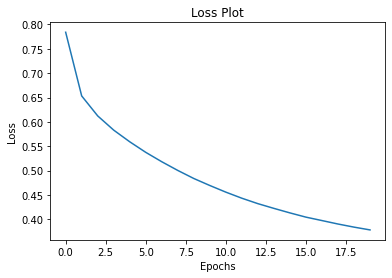

In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

###**Caption**

*  The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the end token.
* And store the attention weights for every time step.

In [ ]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([word_to_index('<start>')], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        predicted_word = tf.compat.as_text(index_to_word(predicted_id).numpy())
        result.append(predicted_word)

        if predicted_word == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [ ]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(int(np.ceil(len_result/2)), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

### **RESULTS**

Real Caption: <start> a kitchen filled with metal counters and stools. <end>
Prediction Caption: people are working in a section <end>


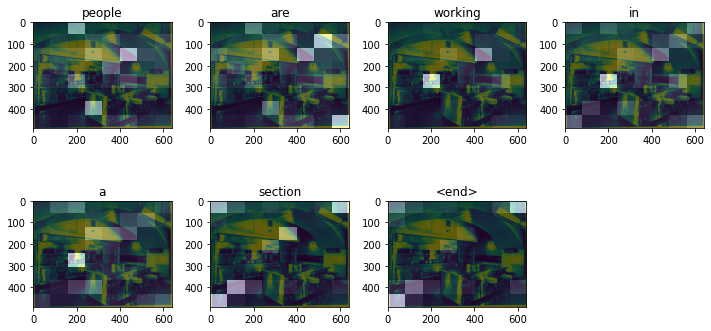

In [ ]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy())
                         for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Prediction Caption: a stop at a blue post. <end>


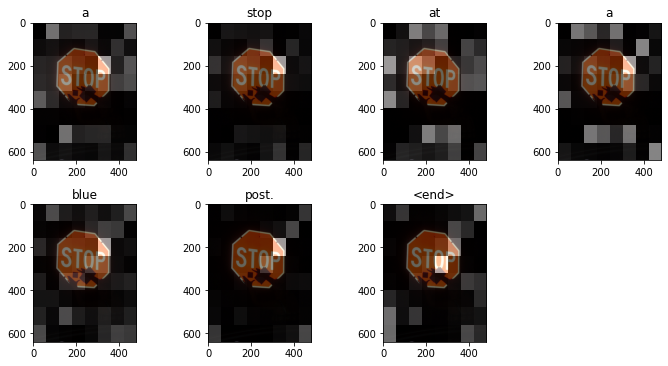

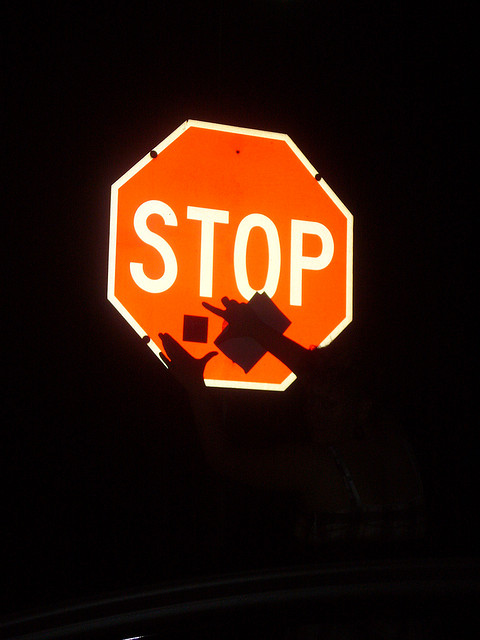

In [ ]:
image_url = 'drive/MyDrive/computer_vision_project/Images/29.jpg'

#printing the caption image wise 
result, attention_plot = evaluate(image_url)
print('Prediction Caption:', ' '.join(result))
plot_attention(image_url, result, attention_plot)

# opening the image
Image.open(image_url)

### **VOICE MODULE**

In [ ]:
# Converting list to string 

re = " "
for i in range(0, len(result)-1): re = re + " " + str(result[i])
print(re)

  a stop at a blue post.


In [ ]:
# Generating voice
mytext = re
language = 'en'
myobj = gTTS(text=mytext, lang=language, slow=False)
myobj.save("description.mp3")

# Playing voice
IPython.display.Audio('description.mp3')